In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

## 1) Define datastructures to store compressed versions of matrices efficiently

### a. Store microscope data:

We will use a run length encoding style format to store the data. Since the virus is a continuous blob, we assume there to be long lengths of similarly colored pixels.

For each row with black pixels, we will store a list of the start and end indices of the black pixels within that row.

### b. Store dye data:

The dye should be quite sparse based on the fact that only 0.1% of the images will have more than 10% filled apart from some leakage, which we are assuming is not too significant.

We will store a list of the coordinates of the dye pixels.

In [2]:
micro_datastructure = {} #Store run length encoded data
dye_datastructure = [] #Store dye data

## Creating fake images and storing them in the datastructures

Too many issues trying to fit a 100000x100000 matrix in memory even using boolean data type. 

So for the example, we will use an arbitrary shape of 100x100, and then zoom in 1000x to get a 100000x100000 matrix. 

Zoom works by repeating each pixel 1000 times in both the x and y directions.

### Fake microscope image generation and encoding

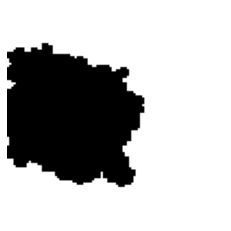

In [3]:
# creating a 1000x1000 image
def generate_arbitrary_shape_microscope(height, width, min_area_ratio=0.25,max_area_ratio = 0.5):
    """ Generates an arbitrary continuous shape of 1s on a 0 background using cellular expansion. """
    image = np.zeros((height, width), dtype=bool)
    area_ratio = np.random.uniform(min_area_ratio, max_area_ratio)
    # Total required area
    min_area = int(height * width * area_ratio)

    # Random starting point (avoiding edges)
    x = random.randint(width // 4, (3 * width) // 4)
    y = random.randint(height // 4, (3 * height) // 4)
    image[y, x] = 1  # Set initial point

    # List of pixels to expand
    expansion_list = [(x, y)]
    area = 1  # Initial area count

    # Directions for random growth (8 directions for arbitrary shape)
    directions = [(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,-1), (1,-1), (-1,1)]
    
    while area < min_area and expansion_list:
        # Pick a random pixel from the existing shape
        random.shuffle(expansion_list)  # Shuffle to make shape more organic
        x, y = expansion_list.pop()
        
        # Try expanding in a random direction
        random.shuffle(directions)  # Shuffle growth directions
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < width and 0 <= ny < height and image[ny, nx] == 0:
                image[ny, nx] = 1
                area += 1
                expansion_list.append((nx, ny))  # Add new pixel to expansion list
                if area >= min_area:
                    break  # Stop if we've filled enough space

    return image

# Generate the shape
image = generate_arbitrary_shape_microscope(100,100)

# Display the result
plt.imshow(image, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
# Converting the image to encoding
def encode_microscope(image, zoom_factor):
    # Note: When encoding an actual image with full 100000x100000 size, if it fits in memory, the zoom would be unneccesary and hence the zoom factor would be 1    
    # However, for the sake of this example image I generated, which doesnt fit in memory, we will use a zoom factor of 1000, to ensure no differences between a real image and the fake genrated image

    #  Find first row with non-zero value using numpy
    first_row = np.nonzero(np.any(image, axis=1))[0][0]
    last_row = np.nonzero(np.any(image, axis=1))[0][-1]
    encoded_image = {}
    area = 0
    
    for i in range(first_row, last_row):
        # Get current row
        row = image[i]
        # Initialize variables for run length encoding
        start = None
        encoding = []
        
        # Process each pixel
        for i, pixel in enumerate(row):
            if pixel == 1 and start is None:
                # Start of a new run of 1s
                start = i
            elif pixel == 0 and start is not None:
                # End of a run of 1s
                end = i - 1
                area += end - start + 1
                encoding.append((start, end))
                start = None
        
        # Handle case where row ends with 1s
        if start is not None:
            end = len(row) - 1
            area += end - start + 1
            encoding.append((start, end))
        encoded_image[i] = encoding    # Zoom the encoding by the zoom factor
    zoomed_encoded_image = {}
    for i in encoded_image:
        zoomed_row_index = i * zoom_factor
        for j in range(zoomed_row_index, zoomed_row_index + zoom_factor):
            zoomed_encoded_image[j] = [(start*zoom_factor, end*zoom_factor) for start, end in encoded_image[i]]
    
    return zoomed_encoded_image, area*(zoom_factor**2)

In [5]:
encoded_image, virus_area = encode_microscope(image, 1000)

### Fake dye image generation and encoding

In [6]:
def generate_arbitrary_spots_dye(height, width, virus_area, zoom_factor):
    # Generates an arbitrary number of arbritary shaped spots of dye on a 0 background.
    
    # Known Fact: The total area of dye spots will be between 0 and 10% of the total area of the fake microscope image with a 99.9% chance, and random number from 10% - 100% of the total area of the fake microscope image with a 0.1% chance
    # Assumption: Accounting for the area covered by leaked dye will increase the total area of dye spots by a random number between 10% - 20%
    
    # Returning an encoded image of dye spots that include a list of pixel coordinates of the dye spots


    # Calculating total dye area
    virus_area = (virus_area // zoom_factor**2)
    image_pixels = set()
    leakage_area_ratio = np.random.uniform(0.1, 0.2)
    non_cancer_parasite_area_ratio = np.random.uniform(0, 0.1)
    cancer_parasite_area_ratio = np.random.uniform(0.1,1)
    # Generate parasite type with 99.9% probability of non-cancer and 0.1% probability of cancer
    parasite_area_ratio = np.random.choice(
        [non_cancer_parasite_area_ratio, cancer_parasite_area_ratio], 
        p=[0.999, 0.001]
    )
    total_dye_area_ratio = parasite_area_ratio * (1 + leakage_area_ratio)
    total_dye_area = int(virus_area * total_dye_area_ratio)

    # Generate random number of spots (between 3 and 8)
    num_spots = random.randint(3, 20)
    
    # Generate random areas that sum to total_dye_area
    spot_areas = []
    remaining_area = total_dye_area
    
    # Generate random proportions for all spots except the last one
    for i in range(num_spots - 1):
        # Generate a random area between 10-50% of remaining area
        area = random.randint(int(0.1 * remaining_area), int(0.5 * remaining_area))
        spot_areas.append(area)
        remaining_area -= area
    
    # Add the remaining area to the last spot
    spot_areas.append(remaining_area)
    
    # Shuffle the areas for randomness
    random.shuffle(spot_areas)

    for spot_area in spot_areas:
        x = random.randint(0, width - 1)
        y = random.randint(0, height - 1)
        image_pixels.add((x, y))
        expansion_list = [(x, y)]
        area = 1 

        # Directions for random growth (8 directions for arbitrary shape)
        directions = [(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,-1), (1,-1), (-1,1)]
        
        while area < spot_area and expansion_list:
            # Pick a random pixel from the existing shape
            random.shuffle(expansion_list)  # Shuffle to make shape more organic
            x, y = expansion_list.pop()
            
            # Try expanding in a random direction
            random.shuffle(directions)  # Shuffle growth directions
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height and ((nx, ny) not in image_pixels):
                    image_pixels.add((nx, ny))
                    area += 1
                    expansion_list.append((nx, ny))  # Add new pixel to expansion list
                    if area >= spot_area:
                        break
    zoom_image_pixels = []
    dx,dy = np.indices((zoom_factor,zoom_factor))
    count = 0
    for x,y in image_pixels:
        new_coords = np.array([(x*zoom_factor + dx_, y*zoom_factor + dy_) for dx_, dy_ in zip(dx.ravel(), dy.ravel())])
        zoom_image_pixels.append(new_coords)
        count += 1
        if count % 10 == 0:
            print(f"Zooming in: Processed {count} pixels out of {len(image_pixels)}")

    zoom_image_pixels = np.concatenate(zoom_image_pixels)
    return zoom_image_pixels, image_pixels
    

In [7]:
dye_image_pixels, display_image_pixels = generate_arbitrary_spots_dye(100, 100, virus_area, 1000)

Zooming in: Processed 10 pixels out of 100
Zooming in: Processed 20 pixels out of 100
Zooming in: Processed 30 pixels out of 100
Zooming in: Processed 40 pixels out of 100
Zooming in: Processed 50 pixels out of 100
Zooming in: Processed 60 pixels out of 100
Zooming in: Processed 70 pixels out of 100
Zooming in: Processed 80 pixels out of 100
Zooming in: Processed 90 pixels out of 100
Zooming in: Processed 100 pixels out of 100


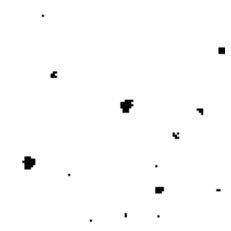

In [8]:
# Create a 100x100 matrix filled with zeros
dye_image = np.zeros((100, 100))

# Set pixels from dye_image_pixels to 1
for x, y in display_image_pixels:
    dye_image[x, y] = 1
plt.imshow(dye_image, cmap='binary')
plt.axis('off')
plt.show()


### 3) Compute whether the parasite has cancer or not

For each pixel in the dye image, we will check if it is within the virus area.

We can then use the total dye area to compare to virus area to determine if the parasite has cancer or not.

We have the virus area from our microscope image encoding function.

In [9]:
# Binary Search for the highest lower or equal value, helps in finding if a dye pixel is in a run length encoded microsocpe image row
def binary_search_highest_lower(lst, x):
    low, high = 0, len(lst) - 1
    result = None
    
    while low <= high:
        mid = (low + high) // 2
        if lst[mid][0] <= x:  # Changed < to <= to include equal values
            result = mid
            low = mid + 1
        else:
            high = mid - 1
    
    return result

In [10]:
def check_cancer(dye_image_pixels, microscope_encoded_image, virus_area):
    # Checking if the parasite has cancer
    # Returns True if the parasite has cancer, False otherwise
    
    # First calculate dye area inside the virus
    dye_area_inside_virus = 0
    for pixel in dye_image_pixels:
        pixel_x = pixel[0]
        pixel_y = pixel[1]
        if pixel_x in microscope_encoded_image:
            microscope_encoded_row = microscope_encoded_image[pixel_x]
            current_position = 0
            is_inside = False
            if pixel_x in microscope_encoded_image:
                nearest_idx = binary_search_highest_lower(microscope_encoded_row, pixel_y)
                if nearest_idx is not None:
                    if microscope_encoded_row[nearest_idx][0] <= pixel_y <= microscope_encoded_row[nearest_idx][1]:
                        is_inside = True
            if is_inside:
                dye_area_inside_virus += 1

    # return whether dye area inside virus is greater than 10% of virus area
    return dye_area_inside_virus > 0.1*virus_area

check_cancer(dye_image_pixels, encoded_image, virus_area)

False

### 4) Improving speed of the check_cancer function

Analyzing the time complexity of the check_cancer function:

We loop over every active pixel in the dye image, we choose the matching row in the encoded image which is constant time, we then use binary search to find the nearest index to the pixel y coordinate, which is log(m) time.

Hence, the time complexity is O(nlog(m)) where n is the number of pixels in the dye image, and m is the number of pixels in each row encoded image a.k.a the width of the image.

This is the best we can do with the current encoding method of compressed microscope and dye image.

However, if we have the ability to store the entire microscope image in memory, for each pixel in the dye image, we can just check if it is in the virus area in constant time.

So time complexity of the check_cancer function is O(n) if we store the entire microscope image in memory.

In [12]:
# The following is a way to check cancer with full microscope image in memory without any encoding
# We wont test this because of memory constraints
def check_cancer_with_full_microscope_image(dye_image_pixels, microscope_image, virus_area):
    # Checking if the parasite has cancer
    # Returns True if the parasite has cancer, False otherwise
    
    # First calculate dye area inside the virus
    dye_area_inside_virus = 0
    for pixel in dye_image_pixels:
        pixel_x = pixel[0]
        pixel_y = pixel[1]
        if microscope_image[pixel_x, pixel_y] == 1:
            dye_area_inside_virus += 1
    return dye_area_inside_virus > 0.1*virus_area



### 5) Other compression techniques and runtime analysis

We can use coordinate storage to store the microscope image as well. This will likely take up more space than the run length encoding, and be less efficient in cancer detection as microsocpe image is continuous.

We can use run length encoding to store the dye image as well. This will likely take up more space than the coordinate storage, and be less efficient in cancer detection as dye pixels are not contiguous and quite sparse.

As mentioned in the previous section, the best we can do in time complexity to check cancer is O(n) if we store the entire microscope image in memory.

#### Checking storage and runtime

We have already generated the fake microscope and dye images to the full dimensions in their encoded format. Even though these are not perfect, they can be representative of a typical real image. We can use that to check the storage used and the runtime of the cancer check function.

In [13]:
# Check storage of encoded microscope image
import sys
encoded_microscope_image_size = sys.getsizeof(encoded_image)
print(f"Encoded microscope image size: {encoded_microscope_image_size} bytes")

# Check storage of dye image coordinates
dye_image_coords_size = sys.getsizeof(dye_image_pixels)
print(f"Dye image coordinates size: {dye_image_coords_size} bytes")

# For comparison, calculate theoretical size of full uncompressed image
# Assuming each pixel takes 1 byte
full_image_size = 100000 * 100000
print(f"Full uncompressed image would take: {full_image_size} bytes")

compression_ratio = full_image_size / encoded_microscope_image_size
print(f"Compression ratio: {compression_ratio:.2f}x")


Encoded microscope image size: 36960 bytes
Dye image coordinates size: 1600000128 bytes
Full uncompressed image would take: 10000000000 bytes
Compression ratio: 270562.77x


In [14]:
# check runtime of cancer check function
import time
start_time = time.time()
cancer_result = check_cancer(dye_image_pixels, encoded_image, virus_area)
end_time = time.time()
print(f"Cancer check runtime: {end_time - start_time} seconds")



Cancer check runtime: 11.985249519348145 seconds


Note: Even though in this example, run length encoding would have taken lesser space than coordinate storage for dye image, in a real scenario, the run length encoding would have taken more space than coordinate storage due to it being more arbitrary.

### 6) LLM Techniques and tools used

For this project, I have mainly utilized  ChatGPT to help get a better understanding of the problem and to suggest different techniques to solve it. These ideas were then analyzed, and further refined and improved by me.

I have also coded using Cursor AI Editor, which provides an Claude 3.5 Sonnet model to help me write the code, and provide some autocompletes for faster development. While the LLM couldn't generate the entire code for the project all at once, it was able to help generate small useful code snippets that could helped improve my productivity.

The only major tool apart from LLMs was the python numpy library, which I used mainly to perform matrix operations. Apart from this, most of the code is written in simple basic python.